# Preprocessing for Clustering 2.

En esta iteración intentaremos agrupar a los clientes según el beneficio que aporta a nuestra compañía. Para ello, se realizará un target encoding usando como referencia el profit de los clientes. También omitiremos los factores de localización, como el market y la región.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer

import sys
sys.path.append("../..")

from src.support_prep import *
from src.support_eda import plot_col
from src.support_clustering import *

import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_pickle("../../datos/clean.pkl")
df = df.drop(columns = ["order_date", "ship_date", "country"])

In [5]:
df.head()

,ship_mode,segment,market,region,category,sub-category,sales,quantity,discount,profit,shipping_cost,order_priority
0,Same Day,Consumer,US,East,Technology,Accessories,2309.650,7,0.0,762.1845,933.57,Critical
1,Second Class,Corporate,APAC,Oceania,Furniture,Chairs,3709.395,9,0.1,-288.7650,923.63,Critical
2,First Class,Consumer,APAC,Oceania,Technology,Phones,5175.171,9,0.1,919.9710,915.49,Medium
3,First Class,Home Office,EU,Central,Technology,Phones,2892.510,5,0.1,-96.5400,910.16,Medium
4,Same Day,Consumer,Africa,Africa,Technology,Copiers,2832.960,8,0.0,311.5200,903.04,Critical


In [6]:
cat_cols = df.select_dtypes("O").columns
num_cols = df.select_dtypes("number").columns

## Encoding

Como se menciono anteriormente, aplicaremos un target encoder.

In [7]:
df_target = df.copy()

df_encoded, encoder = encode_target(data = df_target, columns = cat_cols, response_var = "profit")


In [8]:
df_target[cat_cols] = df_encoded[cat_cols]

In [9]:
df_target.head()

,ship_mode,segment,market,region,category,sub-category,sales,quantity,discount,profit,shipping_cost,order_priority
0,28.201802,28.254008,28.656896,32.135808,65.454958,42.154896,2309.650,7,0.0,762.1845,933.57,31.593124
1,28.381368,28.596042,39.629163,34.439091,28.878567,40.884178,3709.395,9,0.1,-288.7650,923.63,31.593124
2,27.728804,28.254008,39.629163,34.439091,65.454958,64.556749,5175.171,9,0.1,919.9710,915.49,29.361729
3,27.728804,29.648847,37.282974,28.011512,65.454958,64.556749,2892.510,5,0.1,-96.5400,910.16,29.361729
4,28.201802,28.254008,19.374674,19.374674,65.454958,116.314687,2832.960,8,0.0,311.5200,903.04,31.593124


## Feature Scaling

En cuanto al scaling, en el EDA pudimos ver que nuestros datos presentaban muchos outliers, de los cuales nos interesa mantener la información, por lo que usaremos un robust scaler para que las *features* estén todas alrededor de la misma escala, pero conservando la información de atípicos.

In [10]:
df_target_rob, rob_scaler = scale_data(data = df_target, columns = df_target.columns, method = "robust")

## PCA

Para poder intuir el número de clusters que queremos obtener, podemos reducir la dimensionalidad de nuestros datos. En primera instancia nos encontramos con un gran número de columnas, que serían nuestras dimensiones iniciales. Sin embargo, con tantas columnas es muy complicado visualizar los datos de una forma general, por lo que usando un PCA reduciremos las dimensiones a algo más manejable y visualizable, como 3 dimensiones.

In [11]:
pca = PCA(n_components=3)
df_reduced = pd.DataFrame(pca.fit_transform(X = df_target_rob), columns=["x","y","z"])

También podemos comprobar lo bien que el sistema reducido explica la varianza del original.

In [12]:
sum(pca.explained_variance_ratio_)

0.8131580444958737

Un 81% de la varianza es explicable, por lo que es una representación relativamente fiable.

Text(0.5, 0, 'z')

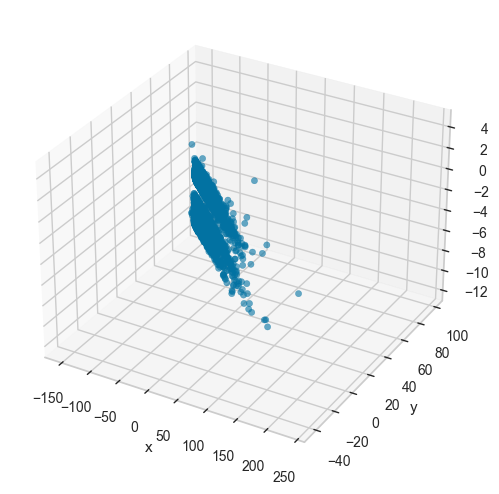

In [13]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = plt.get_cmap("Set1")

sc = ax.scatter(
    df_reduced["x"], 
    df_reduced["y"], 
    df_reduced["z"], 
    s=20, 
    marker='o',
    alpha=0.6
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

Con esta configuración usando el target encoder, vemos que los clusters ya no quedan tan claros. Podrían apreciarse igual 2 clusters, uno encima del otro. Sin embargo, esto es solo una aproximación visual.

## Clustering

### KMeans

Empezaremos probando un modelo de KMeans.

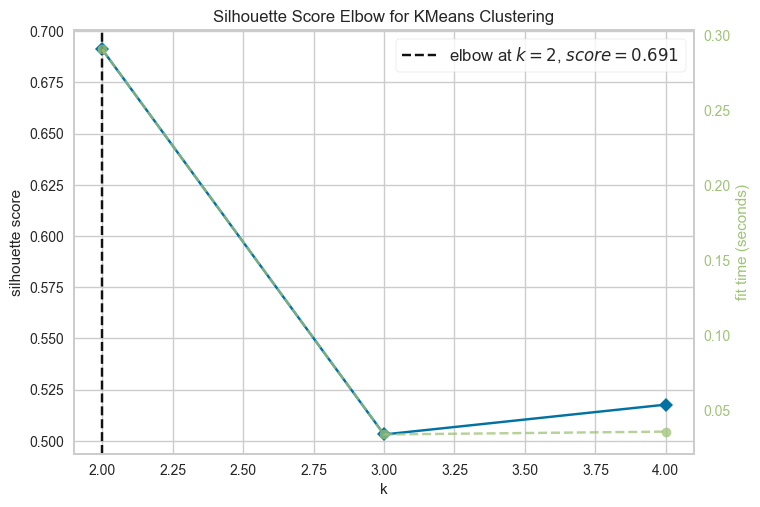

In [14]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(estimator = model, metric = "silhouette", k = (2,5))

visualizer.fit(df_target_rob)
visualizer.show()
plt.show()

Vemos que lo más óptimo son 2 clusters.

In [15]:
modelo = KMeans(n_clusters=2, random_state=42)
modelo.fit(df_target_rob)

KMeans(n_clusters=2, random_state=42)

In [16]:
df_target_rob["cluster"] = modelo.labels_

Text(0.5, 0, 'z')

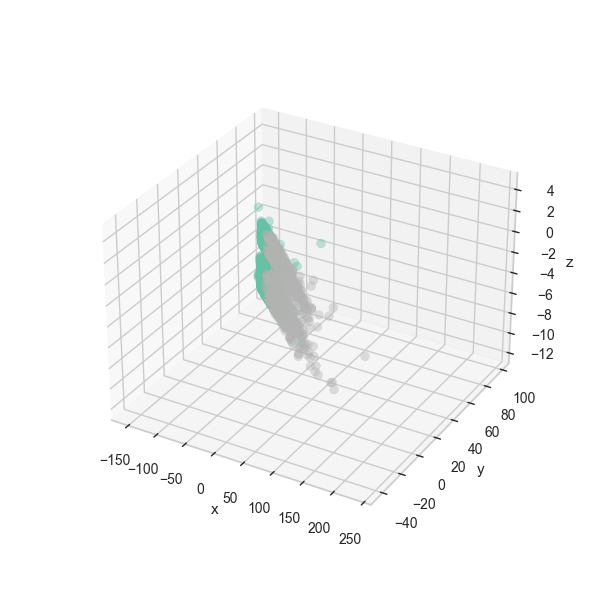

In [17]:
%matplotlib widget

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = plt.get_cmap("Set2")
x = df_target_rob.drop(index = df_target_rob[df_target_rob["cluster"] == -1].index)["cluster"]
sc = ax.scatter(
    df_reduced["x"].drop(index = df_target_rob[df_target_rob["cluster"] == -1].index), 
    df_reduced["y"].drop(index = df_target_rob[df_target_rob["cluster"] == -1].index), 
    df_reduced["z"].drop(index = df_target_rob[df_target_rob["cluster"] == -1].index), 
    c = x,
    cmap = cmap,
    s=40, 
    marker='o',
    alpha=0.4
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# fig.show()

Vemos que la clusterización no es la que se esperaba inicialmente, sin embargo miremos las métricas y las diferencias entre grupos para sacar unas mejores conclusiones.

In [18]:
print(f'Silhouette : {silhouette_score(df_target_rob, df_target_rob["cluster"]):.3f}')
print(f'Davies : {davies_bouldin_score(df_target_rob, df_target_rob["cluster"]):.3f}')

Silhouette : 0.692
Davies : 0.866


Vemos que son métricas bastante buenas, tanto en silhouette como en davies, lo que indica que tenemos clusters bien separados y compactos. Puede que en el PCA no se viera así ya que hay un 20 % restante de variabilidad no explicada, además de que reducir la dimensionalidad puede resultar antiintuitivo a la hora de visualizar los grupos.

En cuanto a la cardinalidad:

In [19]:
df_target_rob["cluster"].value_counts()

cluster
0    49137
1     2153
Name: count, dtype: int64

Observamos que nos ha formado 2 grupos, pero con muchos más datos en el primero que en el segundo.

Separando tipos de datos


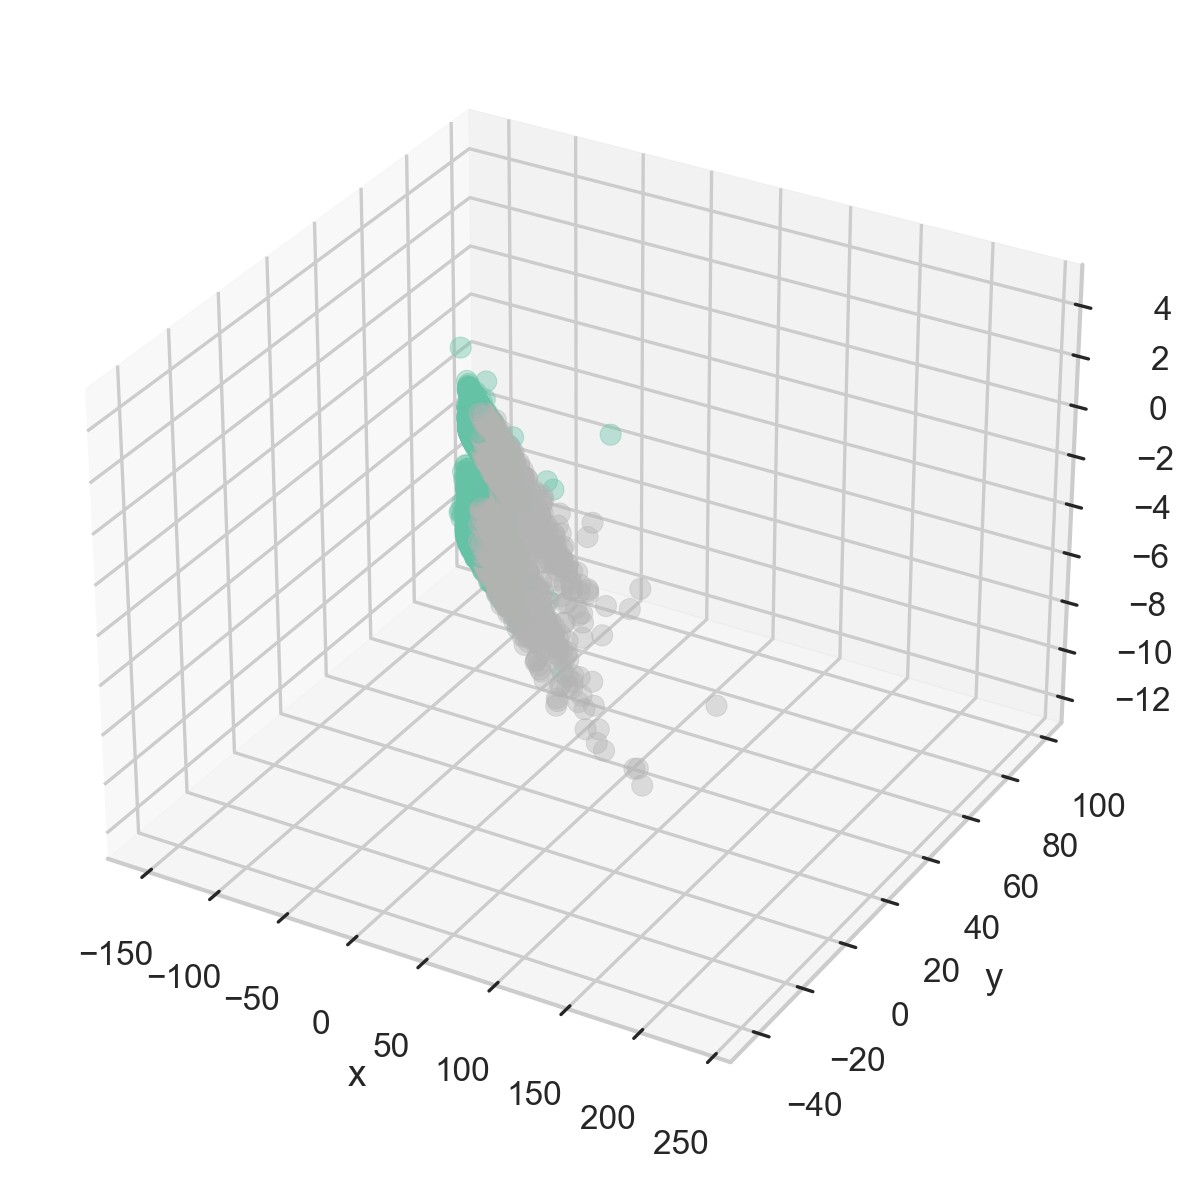

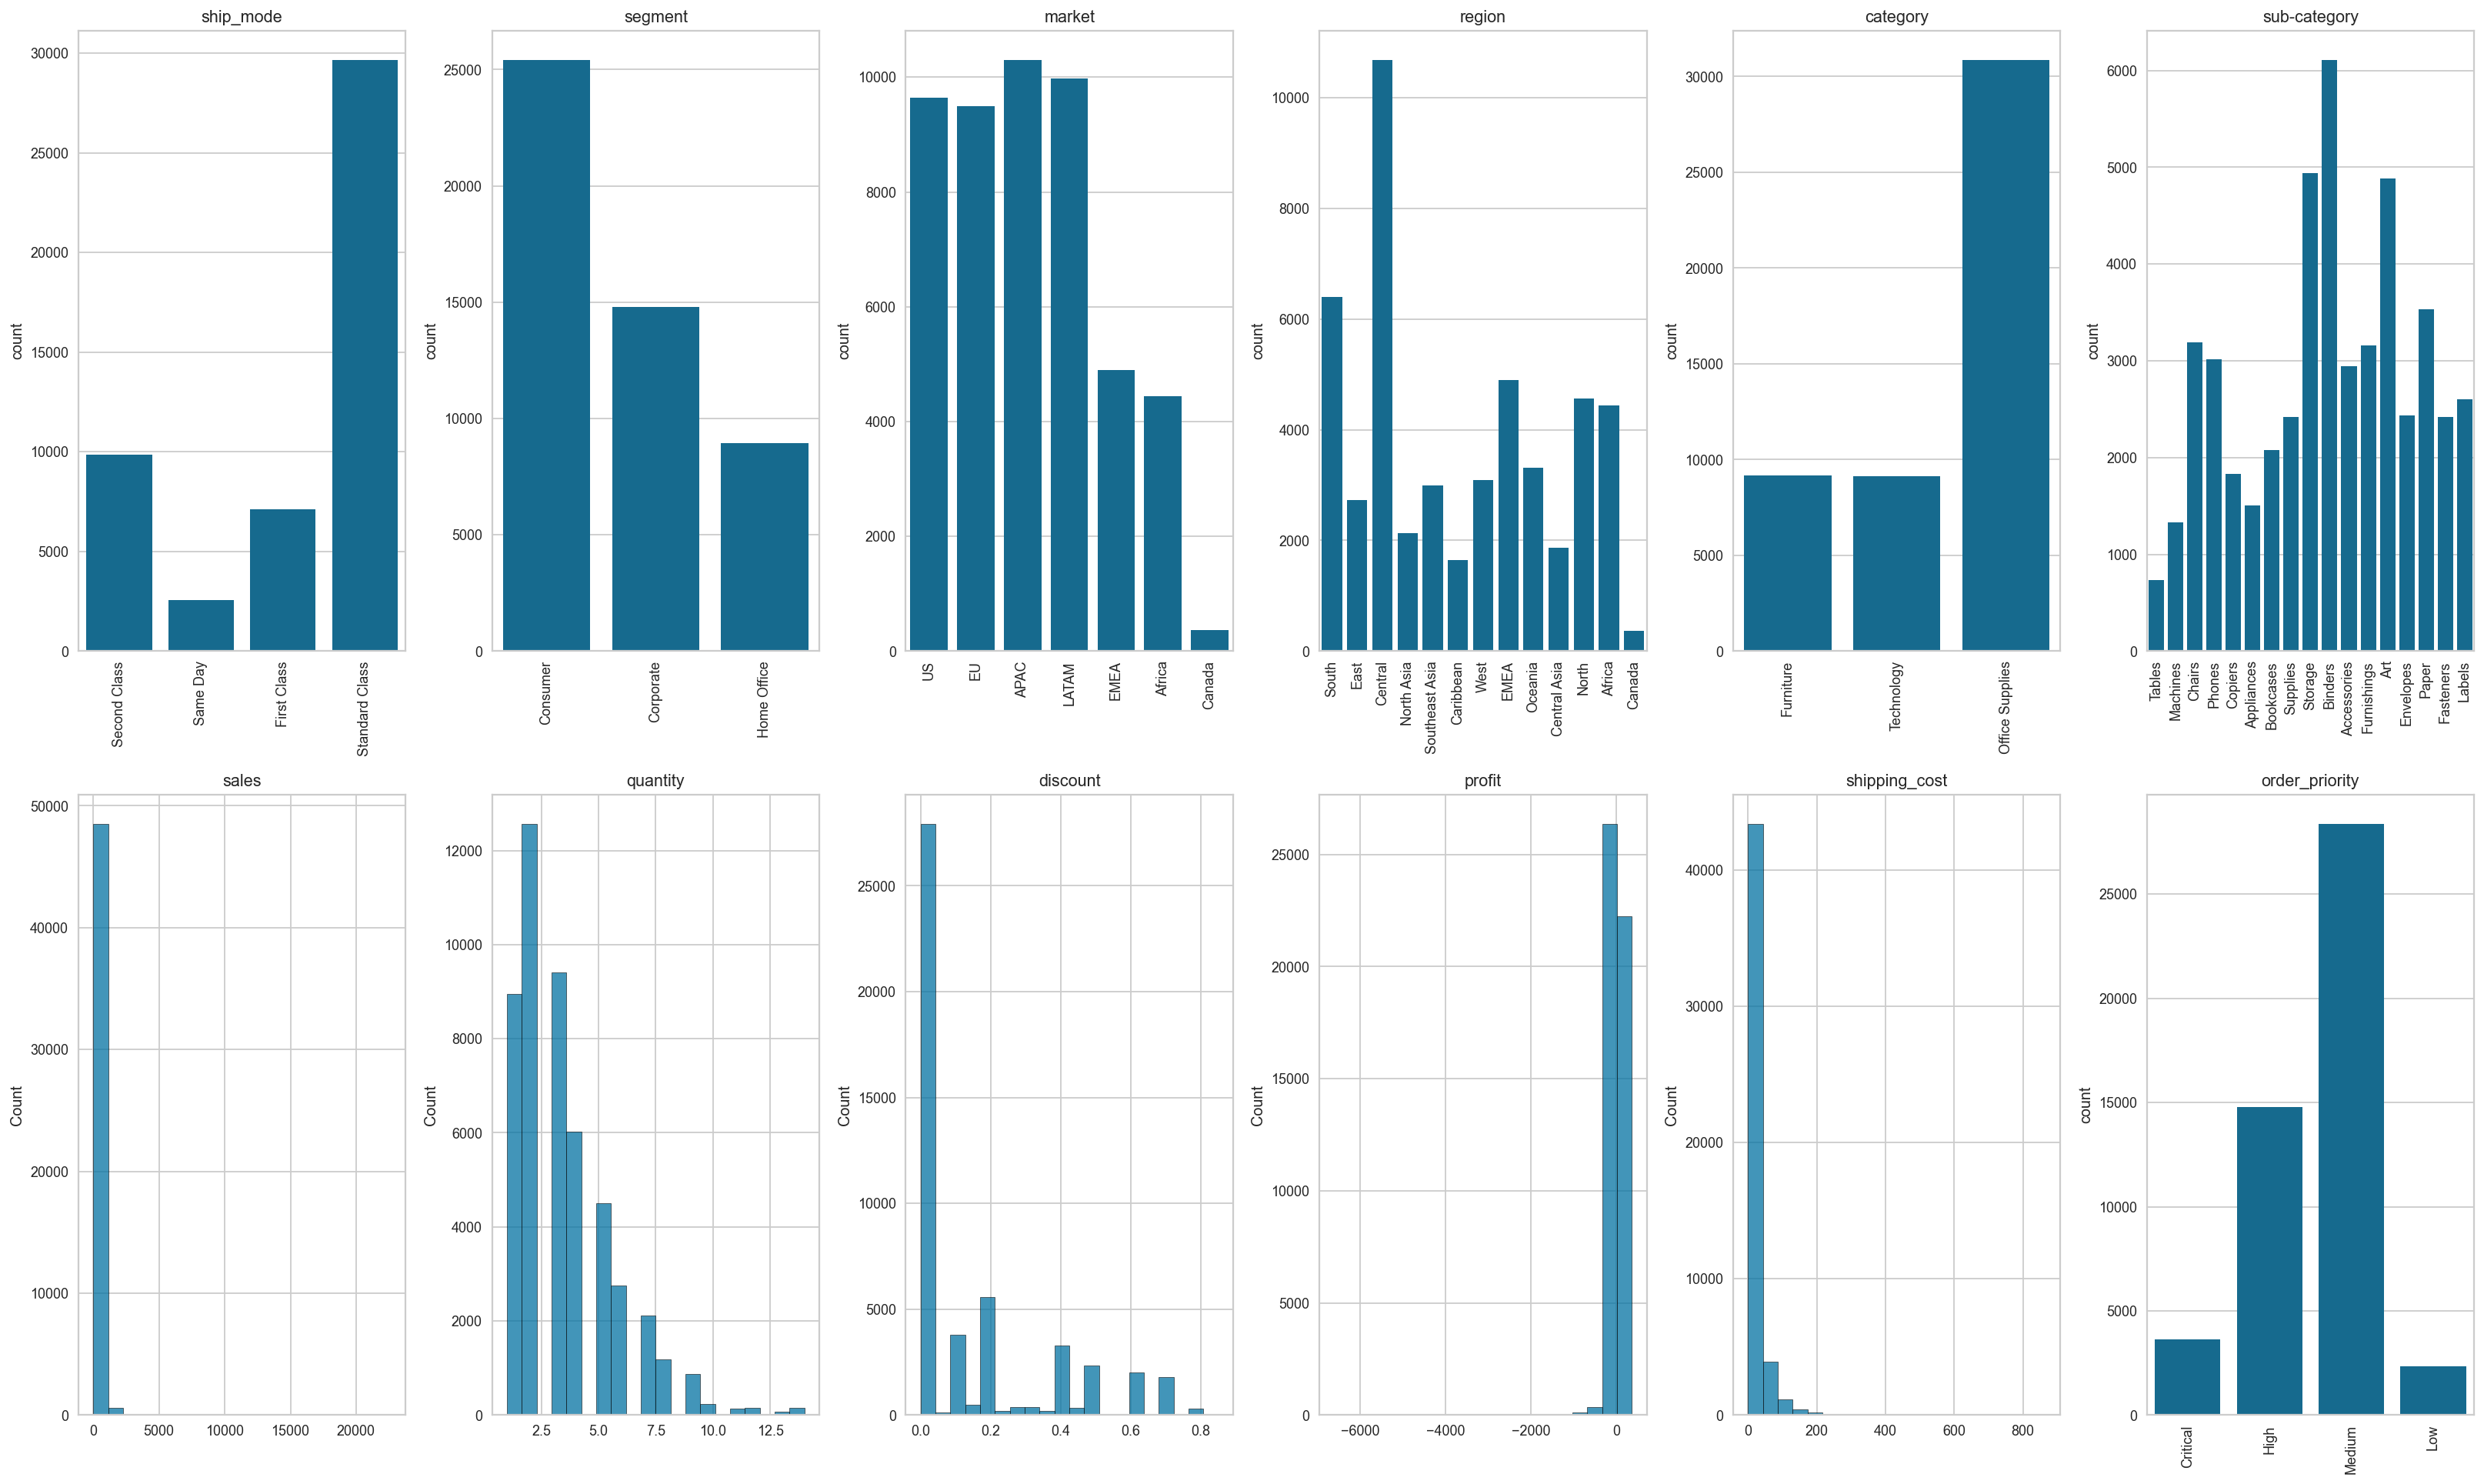

Separando tipos de datos


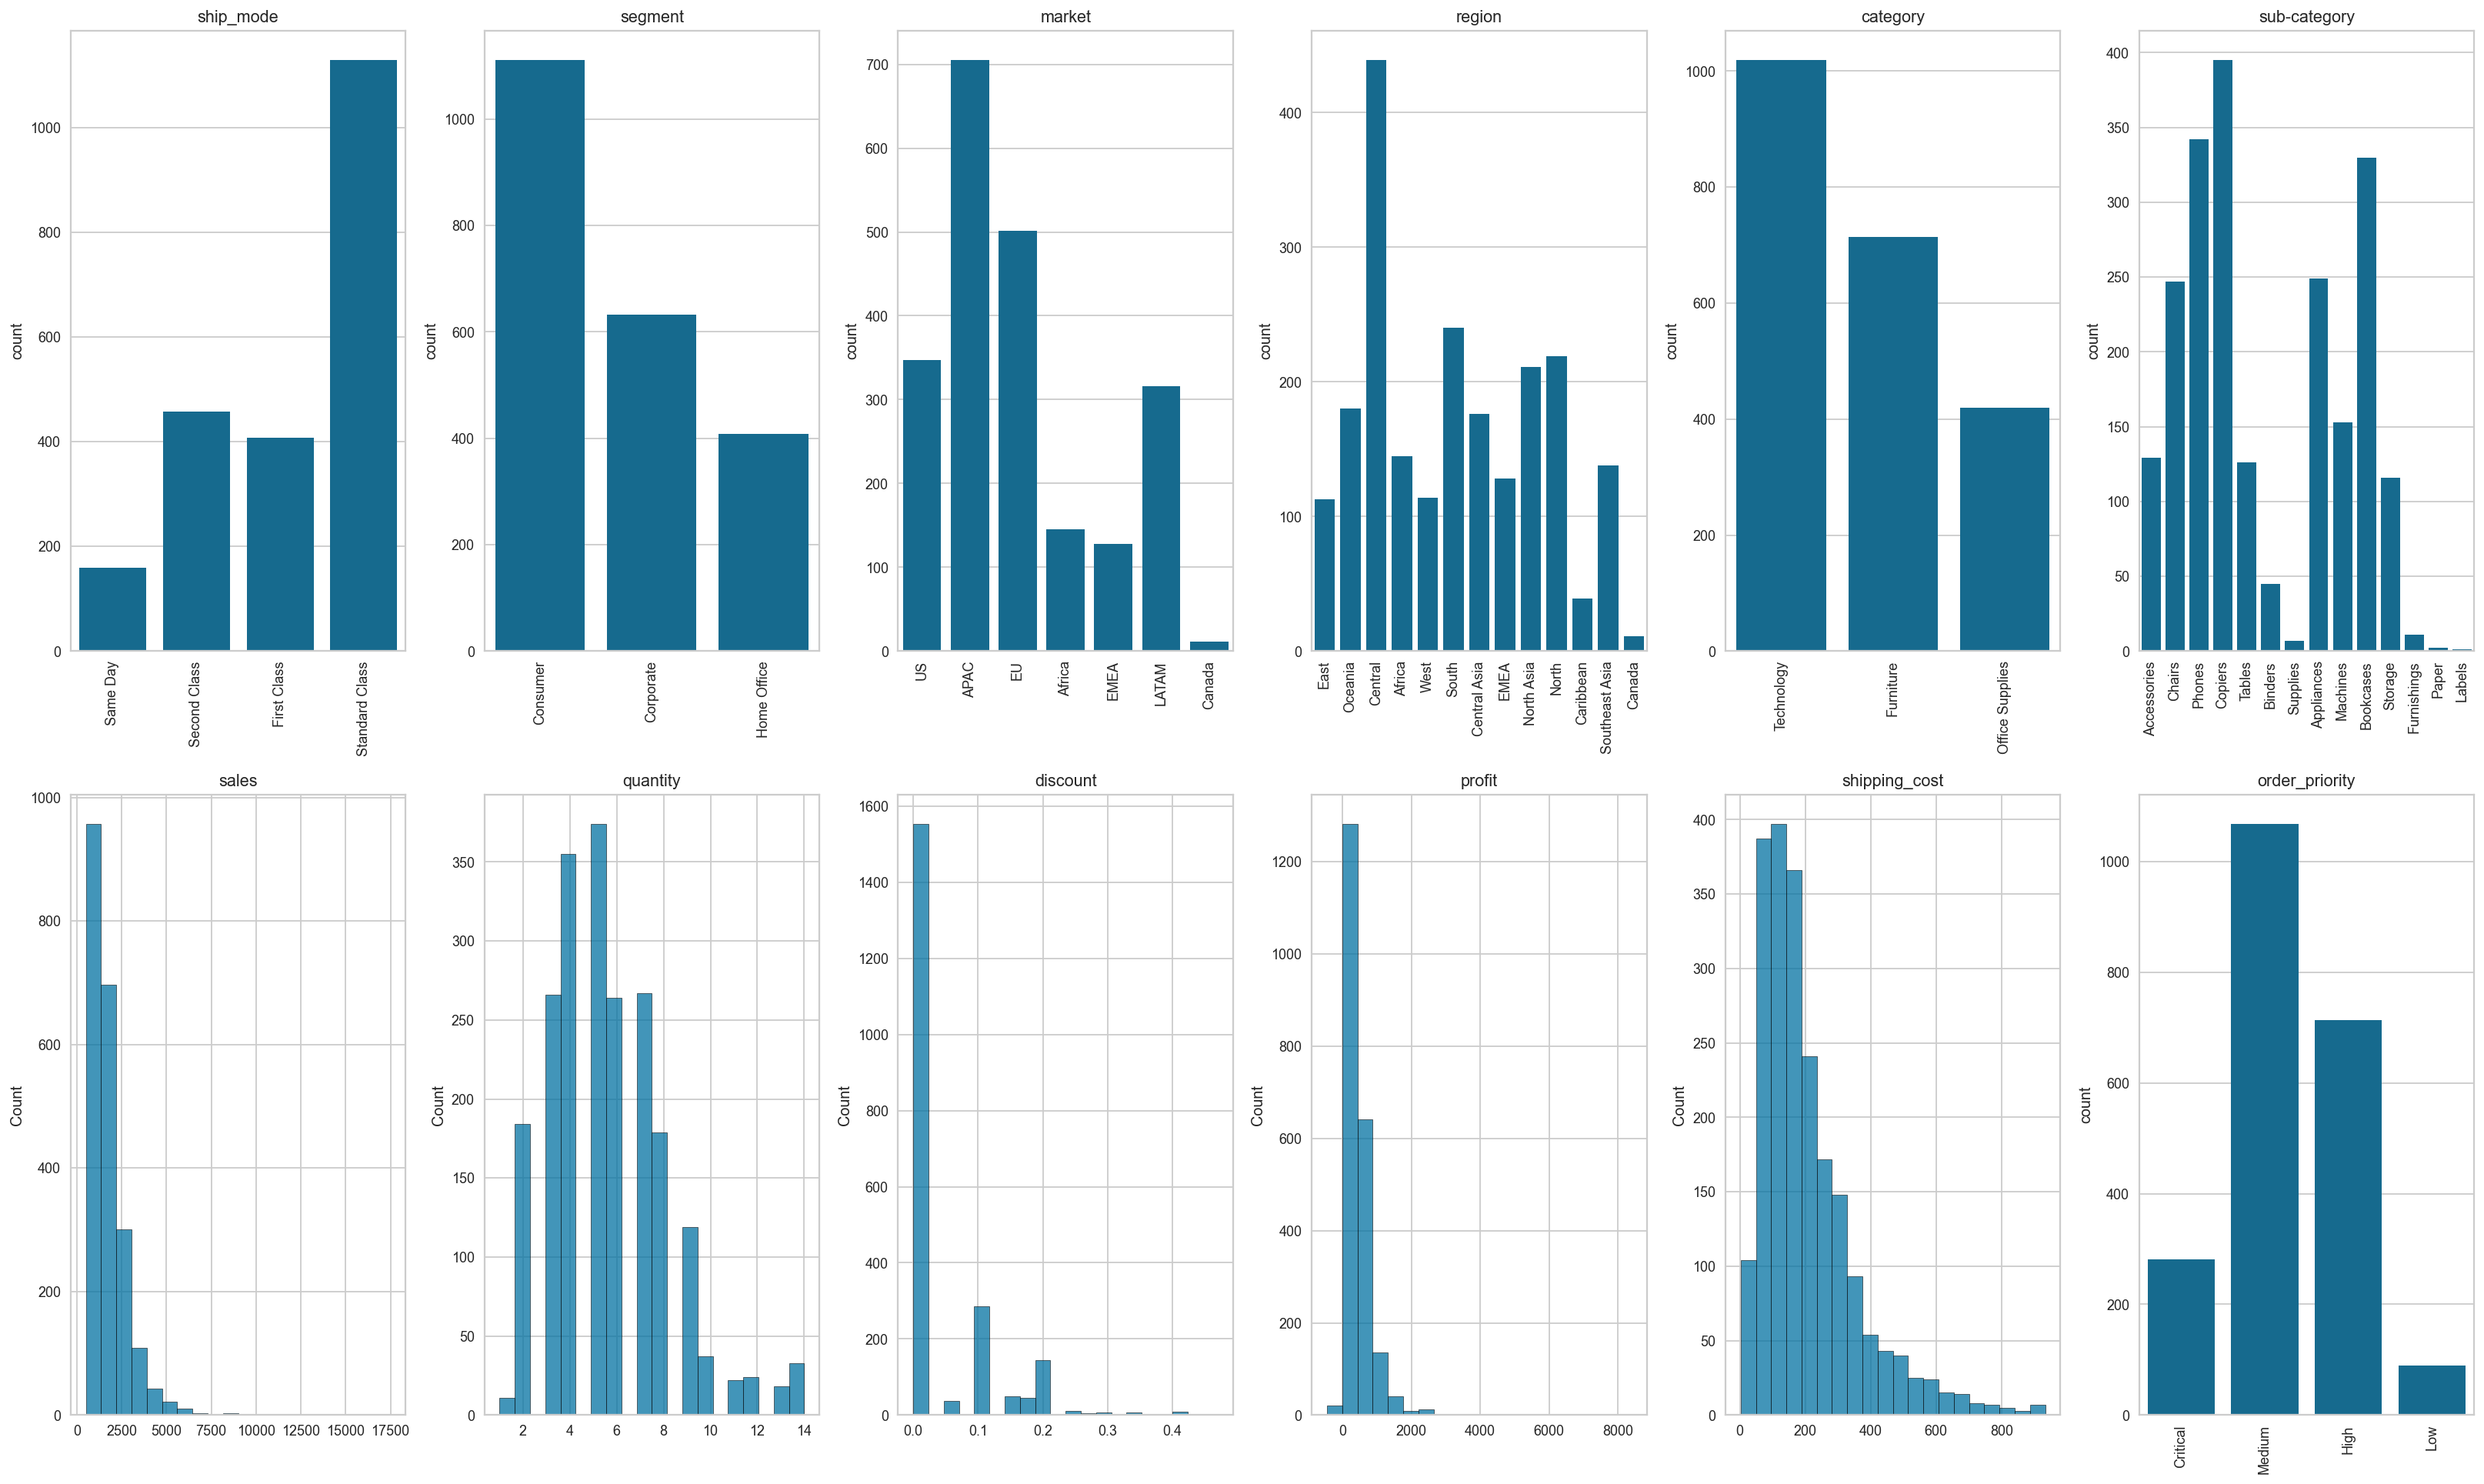

In [20]:
%matplotlib inline

plot_col(df[df_target_rob["cluster"] == 0], x = df.columns)
plot_col(df[df_target_rob["cluster"] == 1], x = df.columns)

En el primer cluster vemos casi todos los pedidos con profit por debajo de 0, es decir, pedidos no rentables, mientras que en el segundo vemos los que sí son rentables. Parece ser que la venta tecnológica es la más rentable para la empresa, además de que el mayor beneficio se obtiene al proporcionar un menor descuento, lo cual es esperable.

La cardinalidad también indica que el cluster más rentable es el minoritario. Para más detalles se realizará un EDA para cada uno de los grupos en la siguiente sección de modelos de regresión.

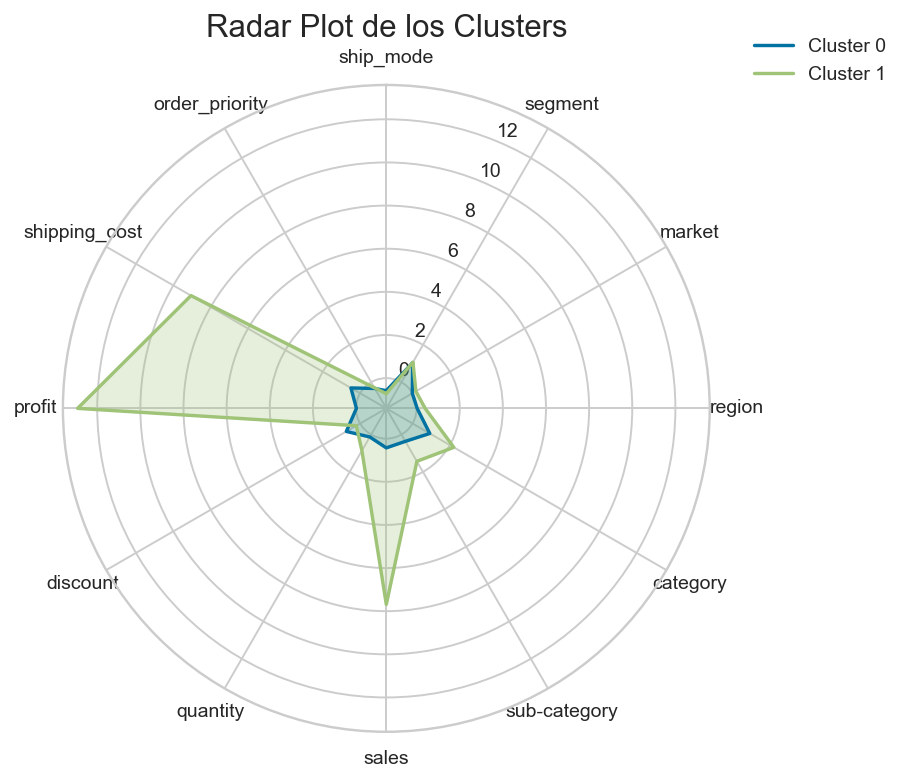

In [21]:
df_noout = df_target_rob.drop(index = df_target_rob[df_target_rob["cluster"]==-1].index)
variables = df_noout.columns.drop("cluster")

cluster_means = df_noout.groupby('cluster')[variables].mean()

# Repetir la primera columna al final para cerrar el radar
cluster_means = pd.concat([cluster_means, cluster_means.iloc[:, 0:1]], axis=1)

# Crear los ángulos para el radar plot
num_vars = len(variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el gráfico

# Crear el radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True), dpi = 140)

# Dibujar un gráfico para cada cluster
for i, row in cluster_means.iterrows():
    ax.plot(angles, row, label=f'Cluster {i}')
    ax.fill(angles, row, alpha=0.25)

# Configurar etiquetas de los ejes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables)

# Añadir leyenda y título
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot de los Clusters', size=16) 
plt.show()

Vemos que los dos clusters se diferencian principalmente en el profit (como era esperable), y alguna otra variable como las ventas o el costo de envío, las cuales se explican con la correlación que tienen con el profit. A primera vista, estos dos clusters sí tienen características diferenciadoras, pero podemos probar algún otro modelo de clustering para comprobar si obtenemos una mejor diferenciación.

### DBSCAN

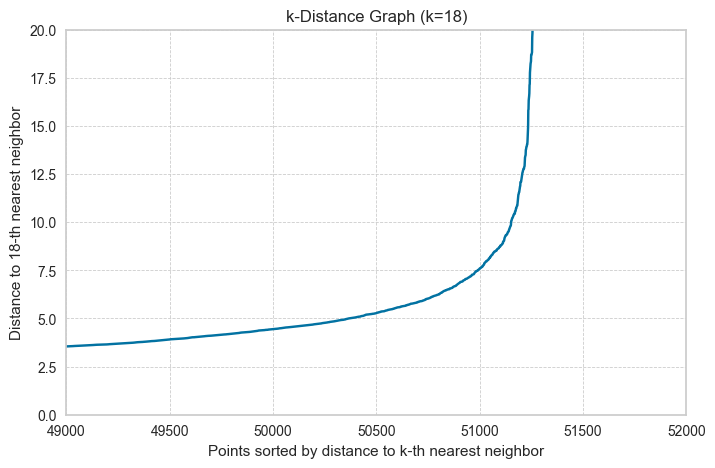

In [22]:
k = int(1.5 * len(df.columns))
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_target_rob)
distances, indices = neighbors_fit.kneighbors(df_target_rob) # Nos va a devolver las distancias y el índice del k-ésimo vecino más cercano.

# Ordenar las distancias al k-ésimo vecino
distances = np.sort(distances[:, k-1], axis=0)  # Selecciona la distancia del k-ésimo vecino


plt.figure(figsize=(8, 5))
plt.grid(ls = "--", lw = 0.6)
sns.lineplot(distances)
plt.title(f"k-Distance Graph (k={k})")
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.ylim(0,20)
plt.xlim(49000, 52000)
plt.show()

In [23]:
modelo = DBSCAN(min_samples=14, eps = 7.5, n_jobs=-1)

modelo.fit_predict(X = df_target_rob)

array([-1, -1, -1, ...,  0,  0,  0], dtype=int64)

In [24]:
df_target_rob["cluster_dbscan"] = modelo.labels_

In [25]:
df_target_rob["cluster_dbscan"].value_counts()

cluster_dbscan
 0    51152
-1      138
Name: count, dtype: int64

Vemos que el DBSCAN no obtiene unos resultados válidos, ya que solo nos detecta los datos que podrían ser ruido, y el resto los junta en un solo grupo.

## Conclusión de la iteración

Tras realizar pruebas con diferentes modelos, nos quedamos con 2 clusters diferenciados por el profit de cada grupo usando KMeans. El siguiente paso será construir modelos predictivos que nos ayuden a predecir beneficio dentro de cada uno de los grupos y extraer insights de cómo aumentarlo.

In [28]:
df_target_rob["cluster"].to_pickle("../../datos/clusters.pkl")